# Environment

In [70]:
try:
    import transformers
except:
    !pip install transformers

In [71]:
import transformers
import pickle
import random
import math
import types

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

In [72]:
torch.__version__

'1.12.1+cpu'

In [73]:
transformers.__version__

'4.21.2'

# Global Config

In [74]:
max_length = 128
batch_size = 32
n_epochs = 10

noise_ratio = 0.15

log_after_step = 50

valid_after_step = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cpu


In [75]:
test_mode = True
if test_mode:
    n_epochs = 1000
    data_length = 1
    batch_size = 1
    log_after_step = 1

In [76]:
!gdown '1dC09i57lobL91lEbpebDuUBS0fGz-LAk' --folder --output data

'gdown' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


# Data

In [77]:
class CSCDataset(Dataset):

    def __init__(self):
        super(CSCDataset, self).__init__()
        with open("data/trainall.times2.pkl", mode='br') as f:
            train_data = pickle.load(f)

        self.train_data = train_data

    def __getitem__(self, index):
        src = self.train_data[index]['src']
        tgt = self.train_data[index]['tgt']
        return src, tgt

    def __len__(self):
        if test_mode:
            return data_length
        return len(self.train_data)

In [78]:
train_data = CSCDataset()

In [79]:
train_data.__getitem__(0)

('纽约早盘作为基准的低硫轻油，五月份交割价攀升一点三四美元，来到每桶二十八点二五美元，而上周五曾下挫一豪元以上。',
 '纽约早盘作为基准的低硫轻油，五月份交割价攀升一点三四美元，来到每桶二十八点二五美元，而上周五曾下挫一美元以上。')

## Dataloader

In [80]:
tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-roberta-wwm-ext")

In [81]:
def collate_fn(batch):
    src, tgt = zip(*batch)
    src, tgt = list(src), list(tgt)

    # src = tokenizer(src, padding='max_length', max_length=max_length, return_tensors='pt', truncation=True)
    inputs = tokenizer(tgt, padding='max_length', max_length=max_length, return_tensors='pt', truncation=True)

    input_ids_with_noise = []
    noise = torch.zeros(batch_size, max_length, 768)
    targets = torch.zeros(len(batch), max_length)
    for i, indices in enumerate(inputs['input_ids']):
        sentence_len = len(indices[indices != 0]) - 1
        noise_len = math.floor(sentence_len * noise_ratio)
        noise_indices = random.sample(range(1, sentence_len), noise_len)
        for j, index in enumerate(noise_indices):
            noise[i][index] = torch.rand(768)

        input_ids_with_noise.append(indices)

        targets[i][noise_indices] = 1

    inputs['input_ids'] = torch.stack(input_ids_with_noise)

    return inputs, targets, noise

In [82]:
train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=collate_fn)

In [83]:
inputs, targets, noise = next(iter(train_loader))

In [84]:
''.join(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))

'[CLS]纽约早盘作为基准的低硫轻油，五月份交割价攀升一点三四美元，来到每桶二十八点二五美元，而上周五曾下挫一美元以上。[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'

In [85]:
vocab = {}
for i, token in enumerate(tokenizer.convert_ids_to_tokens(range(0, len(tokenizer)))):
    vocab[i] = token

In [86]:
import json

with open('vocab.json', 'w', encoding='utf-8') as file:
    file.write(json.dumps(vocab, ensure_ascii=False))

# Model

In [119]:
bert = AutoModel.from_pretrained("hfl/chinese-roberta-wwm-ext")

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [88]:
from typing import Optional, List, Union, Tuple
from transformers.modeling_outputs import BaseModelOutputWithPoolingAndCrossAttentions


def get_embeddings(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
):
    r"""
    encoder_hidden_states  (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
        Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
        the model is configured as a decoder.
    encoder_attention_mask (`torch.FloatTensor` of shape `(batch_size, sequence_length)`, *optional*):
        Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
        the cross-attention if the model is configured as a decoder. Mask values selected in `[0, 1]`:

        - 1 for tokens that are **not masked**,
        - 0 for tokens that are **masked**.
    past_key_values (`tuple(tuple(torch.FloatTensor))` of length `config.n_layers` with each tuple having 4 tensors of shape `(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
        Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.

        If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those that
        don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of all
        `decoder_input_ids` of shape `(batch_size, sequence_length)`.
    use_cache (`bool`, *optional*):
        If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
        `past_key_values`).
    """
    output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
    output_hidden_states = (
        output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
    )
    return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    if self.config.is_decoder:
        use_cache = use_cache if use_cache is not None else self.config.use_cache
    else:
        use_cache = False

    if input_ids is not None and inputs_embeds is not None:
        raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
    elif input_ids is not None:
        input_shape = input_ids.size()
    elif inputs_embeds is not None:
        input_shape = inputs_embeds.size()[:-1]
    else:
        raise ValueError("You have to specify either input_ids or inputs_embeds")

    batch_size, seq_length = input_shape
    device = input_ids.device if input_ids is not None else inputs_embeds.device

    # past_key_values_length
    past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

    if attention_mask is None:
        attention_mask = torch.ones(((batch_size, seq_length + past_key_values_length)), device=device)

    if token_type_ids is None:
        if hasattr(self.embeddings, "token_type_ids"):
            buffered_token_type_ids = self.embeddings.token_type_ids[:, :seq_length]
            buffered_token_type_ids_expanded = buffered_token_type_ids.expand(batch_size, seq_length)
            token_type_ids = buffered_token_type_ids_expanded
        else:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

    # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
    # ourselves in which case we just need to make it broadcastable to all heads.
    extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape)

    # If a 2D or 3D attention mask is provided for the cross-attention
    # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
    if self.config.is_decoder and encoder_hidden_states is not None:
        encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
        encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
        if encoder_attention_mask is None:
            encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
        encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
    else:
        encoder_extended_attention_mask = None

    # Prepare head mask if needed
    # 1.0 in head_mask indicate we keep the head
    # attention_probs has shape bsz x n_heads x N x N
    # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
    # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
    head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

    embedding_output = self.embeddings(
        input_ids=input_ids,
        position_ids=position_ids,
        token_type_ids=token_type_ids,
        inputs_embeds=inputs_embeds,
        past_key_values_length=past_key_values_length,
    )

    return {
        "embedding_output": embedding_output,
        "extended_attention_mask": extended_attention_mask,
        "encoder_extended_attention_mask": encoder_extended_attention_mask,
        "output_attentions": output_attentions,
        "output_hidden_states": output_hidden_states,
        "return_dict": return_dict,
        "use_cache": use_cache,
        "head_mask": head_mask
    }


def post_forward(
        self,
        embedding_output,
        extended_attention_mask,
        encoder_extended_attention_mask,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPoolingAndCrossAttentions]:
    encoder_outputs = self.encoder(
        embedding_output,
        attention_mask=extended_attention_mask,
        head_mask=head_mask,
        encoder_hidden_states=encoder_hidden_states,
        encoder_attention_mask=encoder_extended_attention_mask,
        past_key_values=past_key_values,
        use_cache=use_cache,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
    )
    sequence_output = encoder_outputs[0]
    pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

    if not return_dict:
        return (sequence_output, pooled_output) + encoder_outputs[1:]

    return BaseModelOutputWithPoolingAndCrossAttentions(
        last_hidden_state=sequence_output,
        pooler_output=pooled_output,
        past_key_values=encoder_outputs.past_key_values,
        hidden_states=encoder_outputs.hidden_states,
        attentions=encoder_outputs.attentions,
        cross_attentions=encoder_outputs.cross_attentions,
    )

In [89]:
bert.get_embeddings = types.MethodType(get_embeddings, bert)
bert.post_forward = types.MethodType(post_forward, bert)

In [90]:
embeddings_outputs = bert.get_embeddings(**inputs)
bert.post_forward(**embeddings_outputs)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.2529,  0.4439,  0.2850,  ..., -0.3361,  0.6868,  0.3597],
         [-0.0817,  0.6666,  0.2779,  ..., -0.0320, -0.8320,  0.1756],
         [-0.2023,  0.3854,  0.0892,  ...,  0.3342, -0.7750,  0.0900],
         ...,
         [ 0.3719, -0.0936, -0.4047,  ..., -0.1952,  0.3661,  0.2387],
         [ 0.3607, -0.2736, -0.4350,  ..., -0.3174,  0.3545,  0.2572],
         [ 0.3288, -0.5309, -0.1682,  ...,  0.1320,  0.2335,  0.0326]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 0.9679,  0.8660,  0.9613,  0.3479, -0.1692, -0.6037, -0.0633,  0.6258,
          0.6686, -0.9294,  0.9961,  0.9976,  0.4176, -0.8774,  0.6814, -0.9524,
          0.1755,  0.4708, -0.4872, -0.4379,  0.8697, -0.2062, -0.7883,  0.0814,
          0.7156,  0.5902,  0.6876,  0.3140, -0.9910,  0.9262,  0.9062,  0.9598,
          0.3435, -0.9885, -0.9888, -0.3147, -0.6561,  0.7444,  0.9299, -0.9882,
         -0.8274, -0.5157, -0.10

In [98]:
class CSCModel(nn.Module):

    def __init__(self):
        super(CSCModel, self).__init__()

        self.semantic_encoder = bert

        self.output_layer = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, inputs, noise=None, factor=1):
        embeddings_outputs = self.semantic_encoder.get_embeddings(**inputs)

        # old_embeddings = embeddings_outputs['embedding_output'].clone()

        # if noise is not None:
        #     embeddings_outputs['embedding_output'] = self._add_noise(embeddings_outputs['embedding_output'], noise)

        outputs = self.semantic_encoder.post_forward(**embeddings_outputs)
        outputs = outputs.last_hidden_state

        if noise is not None:
            # 将噪音加载bert后
            outputs = outputs + noise * factor

        return self.output_layer(outputs).squeeze(2)

    def _add_noise(self, embeddings, noise):
        return embeddings + noise

In [99]:
model = CSCModel()
model = model.to(device)

In [100]:
outputs = model(inputs.to(device), noise.to(device))
outputs

tensor([[0.5665, 0.5359, 0.5386, 0.5283, 0.5565, 0.5202, 0.4897, 0.5335, 0.5094,
         0.5146, 0.5254, 0.5342, 0.5416, 0.5206, 0.5596, 0.5899, 0.5513, 0.5106,
         0.5380, 0.5558, 0.5359, 0.5704, 0.5711, 0.5259, 0.5203, 0.5388, 0.5168,
         0.5161, 0.4874, 0.5813, 0.5706, 0.4736, 0.5599, 0.4991, 0.5599, 0.5279,
         0.5520, 0.5002, 0.5317, 0.5117, 0.5314, 0.5011, 0.5675, 0.4650, 0.4737,
         0.5203, 0.5411, 0.5274, 0.5303, 0.5907, 0.5114, 0.5229, 0.5057, 0.4655,
         0.4850, 0.5142, 0.5665, 0.5036, 0.4982, 0.4964, 0.4959, 0.5248, 0.5244,
         0.5319, 0.5327, 0.5270, 0.5317, 0.5236, 0.5190, 0.5179, 0.5249, 0.5128,
         0.5273, 0.5151, 0.5036, 0.5031, 0.5088, 0.5060, 0.5119, 0.5178, 0.5247,
         0.5304, 0.5331, 0.5246, 0.5395, 0.5199, 0.5190, 0.5137, 0.5255, 0.5258,
         0.5182, 0.5213, 0.5288, 0.5400, 0.5453, 0.5384, 0.5413, 0.5353, 0.5311,
         0.5304, 0.5285, 0.5356, 0.5469, 0.5219, 0.5203, 0.5162, 0.5283, 0.5303,
         0.5347, 0.5271, 0.5

# Validation

In [101]:
def predict(text):
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(inputs.to(device))

    segments = []
    last_index = 0
    for index in torch.where(outputs[0, 1:-1] >= 0.5)[0].tolist():
        segments.append(text[last_index:index])
        segments.append("\033[1;31m" + text[index] + "\033[0m")
        last_index = index + 1
    segments.append(text[last_index:])

    return ''.join(segments), (outputs[0, 1:-1] >= 0.5).int()


def validation():
    with open("data/test.sighan15.pkl", mode='br') as f:
        test_data = pickle.load(f)

    total_num = 0
    total_correct = 0

    total_recall_num = 0
    total_recall_correct = 0

    total_precision_num = 0
    total_precision_correct = 0

    prograss = tqdm(range(len(test_data)))
    for i in prograss:
        src, tgt = test_data[i]['src'], test_data[i]['tgt']

        _, output = predict(src)
        target = (torch.tensor(test_data[i]['src_idx']) != torch.tensor(test_data[i]['tgt_idx'])).int()[1:-1].to(device)

        if len(output) != len(target):
            print("第%d条数据异常，请检查" % i)
            break

        total_num += 1
        if (output != target).sum().item() == 0:
            total_correct += 1

        total_recall_correct += output[target == 1].sum().item()
        total_recall_num += (target == 1).sum().item()

        total_precision_num += (output == 1).sum().item()
        total_precision_correct += (target[output == 1]).sum().item()

        accuracy = total_correct / total_num
        recall = total_recall_correct / (total_recall_num + 1e-9)
        precision = total_precision_correct / (total_precision_num + 1e-9)

        prograss.set_postfix({
            'accuracy': accuracy,
            'recall': recall,
            'precision': precision
        })

In [97]:
validation()

 87%|████████▋ | 953/1100 [01:27<00:13, 10.89it/s, accuracy=0.509, recall=0, precision=0]


KeyboardInterrupt: 

# Train

In [102]:
model = model.train()

In [103]:
criteria = nn.BCELoss()
optimizer = torch.optim.Adam(model.output_layer.parameters(), lr=1e-4)

In [104]:
step = 0
total_loss = 0.
total_correct = 0
total_num = 0
total_correct_wrong_char = 0
total_wrong_char = 0

for epoch in range(n_epochs):

    for inputs, targets, noise in train_loader:
        inputs, targets, noise = inputs.to(device), targets.to(device), noise.to(device)
        outputs = model(inputs, noise)
        loss = criteria(outputs, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        step += 1

        total_loss += loss.detach().item()
        total_correct += ((outputs >= 0.5).int() == targets.int()).sum().item()
        total_num += len(targets.flatten())

        # 统计成功预测错字的数量
        total_correct_wrong_char += (outputs >= 0.5)[targets == 1].sum().item()
        # 统计错字的数量
        total_wrong_char += (targets == 1).sum().item()

        if step % log_after_step == 0:
            print("Epoch {}, Step {}, loss {:.5f}, accuracy {:.4f}, recall {:.4f}".format(epoch, step,
                                                                                          total_loss / log_after_step,
                                                                                          total_correct / total_num,
                                                                                          total_correct_wrong_char / total_wrong_char))
            total_loss = 0.
            total_correct = 0
            total_num = 0
            total_correct_wrong_char = 0
            total_wrong_char = 0

        if step % valid_after_step == 0:
            model = model.eval()
            validation()
            model = model.train()

Epoch 0, Step 1, loss 0.74591, accuracy 0.1250, recall 0.8750
Epoch 1, Step 2, loss 0.69944, accuracy 0.3594, recall 0.7500
Epoch 2, Step 3, loss 0.66917, accuracy 0.7578, recall 0.6250
Epoch 3, Step 4, loss 0.63116, accuracy 0.9219, recall 0.5000
Epoch 4, Step 5, loss 0.59788, accuracy 0.9375, recall 0.1250


KeyboardInterrupt: 

# Inference

In [31]:
model = torch.load('csc-model.pt', map_location='cpu')

In [32]:
def predict(text):
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(inputs.to(device))

    segments = []
    last_index = 0
    for index in torch.where(outputs[0, 1:-1] >= 0.5)[0].tolist():
        segments.append(text[last_index:index])
        segments.append("\033[1;31m" + text[index] + "\033[0m")
        last_index = index + 1
    segments.append(text[last_index:])

    return ''.join(segments), (outputs[0, 1:-1] >= 0.5).int()

In [33]:
text, output = predict("昨天下雨了你紫道吗，但是有些词确实太男了")
print(text)
print(output)

AttributeError: 'BertModel' object has no attribute 'get_embeddings'

In [34]:
text

NameError: name 'text' is not defined

# Evaluation

In [35]:
with open("data/test.sighan15.pkl", mode='br') as f:
    test_data = pickle.load(f)

In [36]:
total_num = 0
total_correct = 0

total_recall_num = 0
total_recall_correct = 0

total_precision_num = 0
total_precision_correct = 0

prograss = tqdm(range(len(test_data)))
for i in prograss:
    src, tgt = test_data[i]['src'], test_data[i]['tgt']

    _, output = predict(src)
    target = (torch.tensor(test_data[i]['src_idx']) != torch.tensor(test_data[i]['tgt_idx'])).int()[1:-1].to(device)

    if len(output) != len(target):
        print("第%d条数据异常" % i)

    total_num += 1
    if (output != target).sum().item() == 0:
        total_correct += 1

    total_recall_correct += output[target == 1].sum().item()
    total_recall_num += (target == 1).sum().item()

    total_precision_num += (output == 1).sum().item()
    total_precision_correct += (target[output == 1]).sum().item()

    accuracy = total_correct / total_num
    recall = total_recall_correct / (total_recall_num + 1e-9)
    precision = total_precision_correct / (total_precision_num + 1e-9)

    prograss.set_postfix({
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    })

  0%|          | 0/1100 [00:00<?, ?it/s]


AttributeError: 'BertModel' object has no attribute 'get_embeddings'

# Visualise

In [105]:
inputs, targets, noise = next(iter(train_loader))

In [106]:
embeddings_outputs = bert.get_embeddings(**inputs)
bert.post_forward(**embeddings_outputs)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.1913,  0.4629,  0.1537,  ..., -0.2570,  0.6134,  0.2509],
         [-0.2789,  0.4452,  0.5893,  ...,  0.0723, -0.6717,  0.3080],
         [ 0.1223,  0.6099, -0.1760,  ...,  0.4076, -0.7872, -0.0595],
         ...,
         [ 0.4089,  0.0132, -0.3093,  ..., -0.1026,  0.2535, -0.0268],
         [ 0.3961, -0.2212, -0.4009,  ..., -0.3125,  0.3070,  0.2665],
         [-0.0680, -0.2509, -0.1265,  ...,  0.0023,  0.2936,  0.1970]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 0.9873,  0.9758,  0.9731,  0.2817,  0.1743, -0.5727, -0.3220,  0.4456,
          0.8401, -0.9588,  0.9980,  0.9968, -0.0707, -0.9233,  0.8343, -0.9748,
          0.0422, -0.0530, -0.0390, -0.5145,  0.9843, -0.5351, -0.8328,  0.1778,
          0.6584,  0.7481,  0.7090,  0.0279, -0.9910,  0.9576,  0.8916,  0.9894,
          0.4681, -0.9828, -0.9924, -0.3028, -0.4059,  0.6635,  0.8629, -0.9720,
         -0.7661, -0.6973, -0.19

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.rcParams['font.sans-serif'] = ['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

In [113]:
def token_embeddings_visualise(embeddings, text):
    """
    将汉字文本embedding绘制成图像
    :param embeddings: 文本embedding后的向量，例如Shape为(55, 768)为55个token，每个token维度为768。
                       不要包含bos、eos和pad。embedding需要是numpy类型的
    :param text: 汉字文本，例如 “张三是法外狂徒”。text的长度需要和上面的token数一致
    """
    assert type(embeddings) is np.ndarray, "embedding参数必须是numpy.ndarray类型"
    assert embeddings.shape[0] == len(text), "embedding的token数与text不一致"

    # 1. 将词向量降维到2维度
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(embeddings)
    # 2. 创建一个16x9大小的维度图像
    plt.figure(figsize=(16, 9))
    # 3. 循环绘制文字
    for i in range(len(embeddings)):
        plt.text(embeddings[i][0], embeddings[i][1], text[i])

    # 4. 设置坐标边界
    plt.xlim(embeddings[:, 0].min() - 0.5, embeddings[:, 0].max() + 0.5)
    plt.ylim(embeddings[:, 1].min() - 0.5, embeddings[:, 1].max() + 0.5)
    plt.show()

In [165]:
text = "前天我吃了一大个火聋果"

In [166]:
inputs = tokenizer(text, return_tensors='pt')
outputs = bert(**inputs).last_hidden_state[0, 1:-1]

In [167]:
embeddings = outputs.detach().numpy()

无噪音，bert前


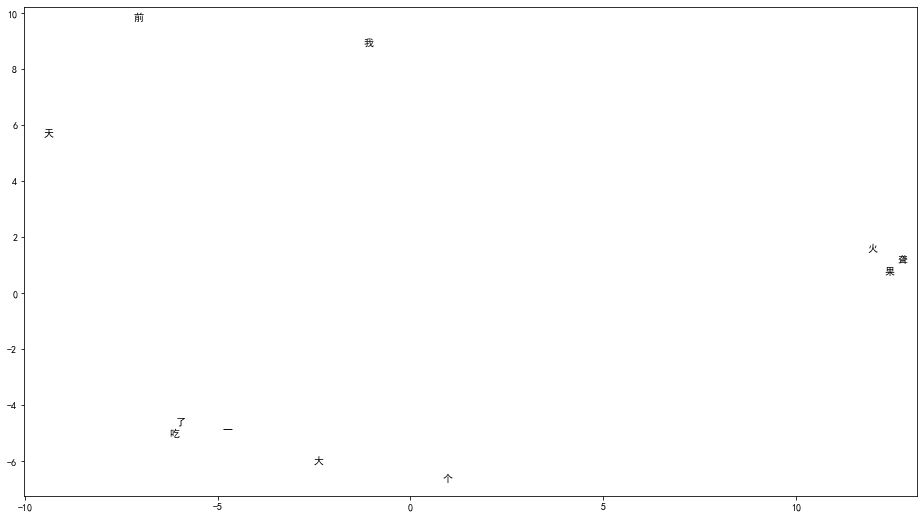

In [168]:
print("无噪音，bert前")
token_embeddings_visualise(embeddings, text)

In [152]:
embeddings = bert(**inputs)['last_hidden_state'][0][1:56].detach().numpy()

In [143]:
print("无噪音，bert编码后")
token_embeddings_visualise(embeddings, text)

无噪音，bert编码后


AssertionError: embedding的token数与text不一致

有噪音, bert前


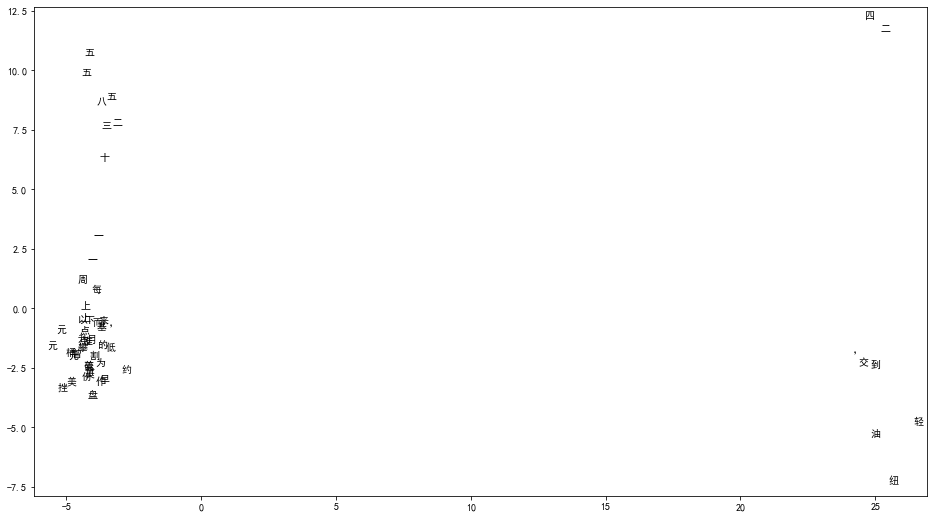

In [75]:
print("有噪音, bert前")
embeddings = (embeddings_outputs['embedding_output'] + noise)[0][1:56].detach().numpy()
token_embeddings_visualise(embeddings, text)

有噪音，bert后


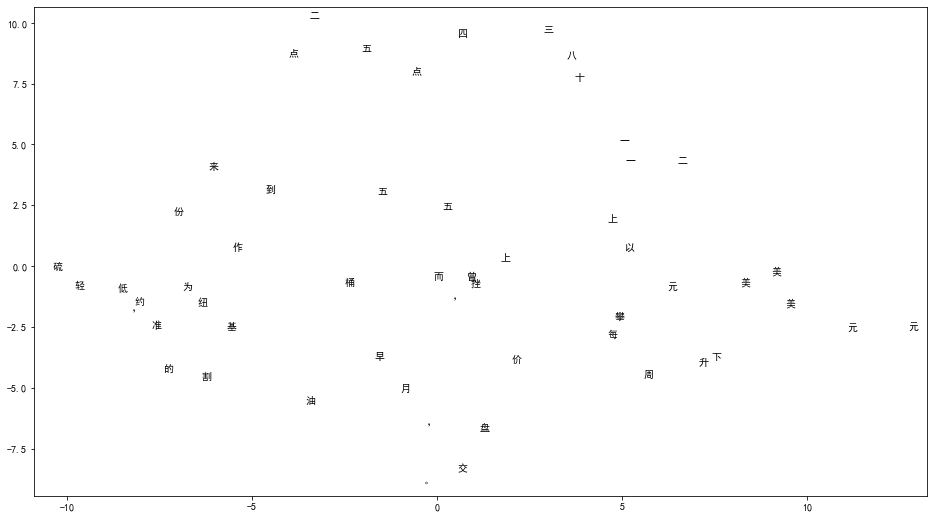

In [76]:
print("有噪音，bert后")
embeddings_outputs['embedding_output'] = embeddings_outputs['embedding_output'] + noise
embeddings = bert.post_forward(**embeddings_outputs)['last_hidden_state'][0][1:56].detach().numpy()
token_embeddings_visualise(embeddings, text)

In [77]:
noise

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.1543, 1.2970, 0.7757,  ..., 1.5602, 0.1108, 1.1854],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])